In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_from_nodes(nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None):

    values = {key: nodes[key]['value'].float().detach().cpu().numpy() for key in nodes.keys() if nodes[key]['name'] != 'samples'}

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=20, alpha=0.7, color='blue', density=True)
        plt.title(key)
        plt.xlabel('value')
        plt.ylabel('frequency')
        sns.despine()
        plt.show()  

    return valuesDF


In [3]:
def samples_to_normalized_counts(samples, grid_length=100):

    linspace = np.linspace(0, 1, grid_length)
    counts, _ = np.histogram(samples, bins=linspace)
    normalized_counts = counts / grid_length
    return normalized_counts

In [4]:
# same as explained in weight_into_notebook
def weight(posterior: List[float], base = 2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1)
    entropy_uniform = entropy(uniform, base=base)
    entropy_posterior = entropy(posterior, base=base)
    return 1 - entropy_posterior/entropy_uniform


weight_of_certainty 1.0


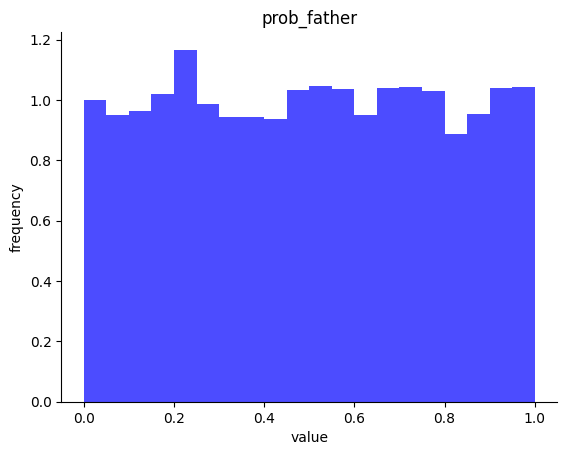

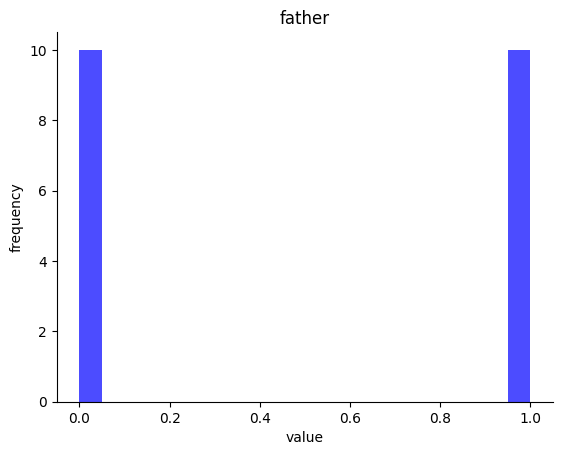

father, prior [0.49970000982284546, 0.5003]
weight_father_prior 2.596681175637272e-07
weight_prob_father_prior 0.0013329514642119733


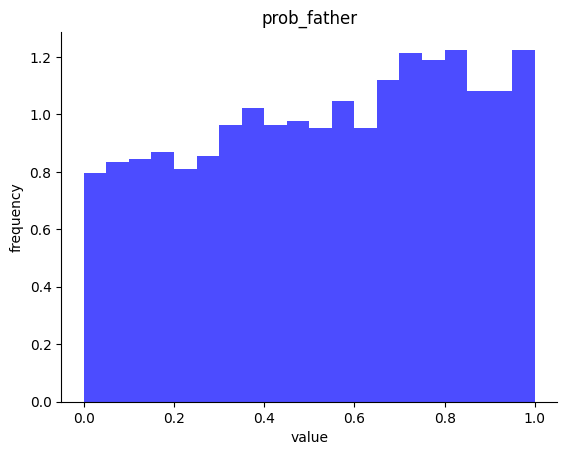

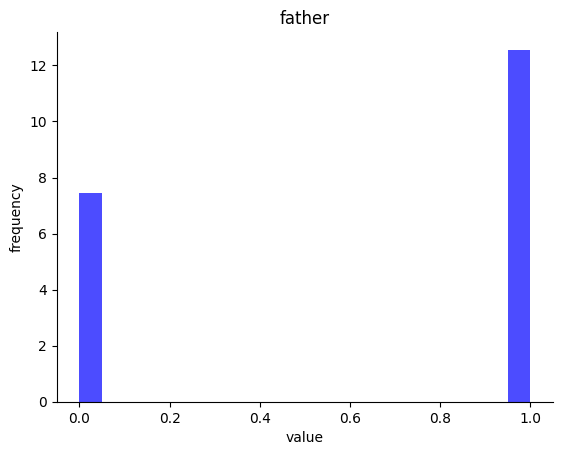

evidence_wo_tinbox_father [0.37195485830307007, 0.62804514]
weight_father_wo_tinbox 0.04783873250011417


,prob_father,father,prob_confession,confession,prob_knife,knife,prob_angle,angle,prob_fingerprints,prob_son_fingerprints,father_fingerprints,son_fingerprints
6,0.384583,0.0,0.7,1.0,0.6,1.0,0.3,1.0,1.000000e-09,9.900000e-01,0.0,1.0
27,0.079583,0.0,0.7,1.0,0.6,1.0,0.3,1.0,1.000000e-09,9.900000e-01,0.0,1.0
31,0.695375,1.0,0.6,1.0,0.5,1.0,0.7,1.0,9.900000e-01,1.000000e-09,1.0,0.0
32,0.874930,1.0,0.6,1.0,0.5,1.0,0.7,1.0,9.900000e-01,1.000000e-09,1.0,0.0
33,0.525496,1.0,0.6,1.0,0.5,1.0,0.7,1.0,9.900000e-01,1.000000e-09,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,0.632270,0.0,0.7,1.0,0.6,1.0,0.3,1.0,1.000000e-09,9.900000e-01,0.0,1.0
9979,0.705769,0.0,0.7,1.0,0.6,1.0,0.3,1.0,1.000000e-09,9.900000e-01,0.0,1.0
9980,0.204012,0.0,0.7,1.0,0.6,1.0,0.3,1.0,1.000000e-09,9.900000e-01,0.0,1.0
9995,0.648306,1.0,0.6,1.0,0.5,1.0,0.7,1.0,9.900000e-01,1.000000e-09,1.0,0.0


6       0.384583
27      0.079583
31      0.695375
32      0.874930
33      0.525496
          ...   
9976    0.632270
9979    0.705769
9980    0.204012
9995    0.648306
9999    0.959818
Name: prob_father, Length: 1683, dtype: float32


In [5]:

def tinbox_model():
   
    prob_father = pyro.sample("prob_father", dist.Beta(1.0, 1.0))
    father = pyro.sample("father", dist.Bernoulli(prob_father))
     
    # confession slightly more probable if father tries to save the son
    prob_confession = pyro.deterministic("prob_confession", 0.7 + father *  - 0.1, event_dim=0)
    confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

    # knife fingerprints match slightly more probable if father tries to save the son
    prob_knife  = pyro.deterministic("prob_knife", 0.6 + father * - 0.1, event_dim=0)
    knife = pyro.sample("knife", dist.Bernoulli(prob_knife))

    # high angle more probable if father is guilty
    prob_angle = pyro.deterministic("prob_angle", 0.3 + father * 0.4, event_dim=0)
    angle = pyro.sample("angle", dist.Bernoulli(prob_angle))


    # imagined tinbox evidence
    # father's fingerprints
    prob_father_fingerprints = pyro.deterministic("prob_fingerprints", 1e-9 + father * 0.99, event_dim=0)
    prob_son_fingerprints = pyro.deterministic("prob_son_fingerprints", 1e-9 + (1-father) * 0.99, event_dim=0)

    father_fingerprints = pyro.sample("father_fingerprints", dist.Bernoulli(prob_father_fingerprints))
    son_fingerprints = pyro.sample("son_fingerprints", dist.Bernoulli(prob_son_fingerprints))




with pyro.poutine.trace() as tr:
    with pyro.plate("samples", size = 10000):
        tinbox_model()


print("weight_of_certainty", weight([0, 1]))

nodes = tr.trace.nodes

priorDf = plot_from_nodes(nodes, nodes_to_plot=["prob_father", "father"])


prior_father = [1 - priorDf["father"].mean(), priorDf["father"].mean()]
print("father, prior", prior_father)
assert prior_father[0] + prior_father[1] == 1

prior_weight_father = weight(prior_father)
print("weight_father_prior", prior_weight_father)

weight_prob_father_prior = weight(samples_to_normalized_counts(priorDf["prob_father"], grid_length=100))
print("weight_prob_father_prior", weight_prob_father_prior)


evidence_wo_tinbox_Df = plot_from_nodes(nodes, 
                                        filters = {"confession": 1,
                                                   "knife": 1,
                                                   "angle": 1,
                                        },
                                        nodes_to_plot=["prob_father", "father"])


evidence_wo_tinbox_father = [1 - evidence_wo_tinbox_Df["father"].mean(), evidence_wo_tinbox_Df["father"].mean()]
evidence_wo_tinbox_weight_father = weight(evidence_wo_tinbox_father)
print("evidence_wo_tinbox_father", evidence_wo_tinbox_father)
print("weight_father_wo_tinbox",  evidence_wo_tinbox_weight_father)

evidence_wo_tinbox_prob_father = weight(samples_to_normalized_counts(evidence_wo_tinbox_Df["prob_father"], 
                                                                     grid_length=100))

print("evidence_wo_tinbox_prob_father", evidence_wo_tinbox_prob_father)



